In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.contrib import lite
import ndjson
import numpy as np
# np.set_printoptions(threshold=np.inf)

coord_space_size = 400
scale_factor = 10
new_size = int(coord_space_size/scale_factor) #will be 40 if sf = 10

def load_ndjson_dataset(filename):
    with open(filename) as f:
        data = ndjson.load(f)
    return(data)

def parse_points(points):
    xMin = coord_space_size
    yMin = coord_space_size
    for point in points:
        if point[0] < xMin:
            xMin = point[0]
        if point[1] < yMin:
            yMin = point[1]
    arr = np.zeros((new_size,new_size), dtype=int)  # Initialize numpy array
    for point in points:
        x = point[0]
        y = point[1]

        x = int((x - xMin) / scale_factor);
        y = int((y - yMin) / scale_factor);

        #flip (x,y) since the android screen follows 3rd quadrant
        arr[y,x] = 1
    return(arr)
    

def parse_ndjson_data(ndjson_data):
    parsed_data = {}
    m=len(ndjson_data)
    labels=np.zeros(m, dtype=int)
    data=np.zeros((m, new_size*new_size), dtype=int)
    for index, data_row_json in enumerate(ndjson_data):
        points = data_row_json["points"]
        label = data_row_json["class"]
        parsed_points = parse_points(points)

        labels[index] = label
        data[index] = parsed_points.flatten()
    parsed_data["data"] = data
    parsed_data["labels"] = labels
    return(parsed_data)

ndjson_data = load_ndjson_dataset("dataset/data.ndjson")
doodle_data=parse_ndjson_data(ndjson_data)

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Dataset 

Each 40x40 image is represented as a 1D array of 1600 entries. There are 3 labels right now and each label has 15 instances. Hence the shape is 45x1600

In [2]:
print(doodle_data["data"].shape)

(100, 1600)


In [3]:
print(doodle_data["labels"].shape)

(100,)


## Labels

We have 3 different labels now.

### Label 1 - Circle

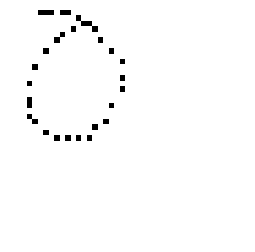

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def draw_doodle(some_doodle):
    some_doodle_image = some_doodle.reshape(40, 40)
    plt.imshow(some_doodle_image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
draw_doodle(doodle_data["data"][0])

### Label 2 - V shape

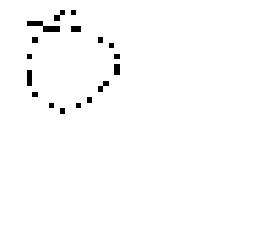

In [5]:
draw_doodle(doodle_data["data"][15])

### Label 3 - ~ shape

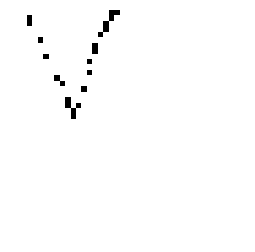

In [6]:
draw_doodle(doodle_data["data"][31])

In [7]:
rows = doodle_data["data"].shape[0]
# no_of_test_examples_per_class = 2
num_classes = 5
# total_train_examples = rows - (no_of_test_examples_per_class * num_classes)
X, y = doodle_data["data"], doodle_data["labels"]
# shuffle_index = np.random.permutation(rows)
# X, y = X[shuffle_index], y[shuffle_index]
# X_train, X_test = X[:total_train_examples], X[total_train_examples:]
# y_train, y_test = y[:total_train_examples], y[total_train_examples:]

# print(y_train)
# print(y_test)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.25,
                                                random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(75, 1600)
(25, 1600)
(75,)
(25,)


In [8]:
y_train

array([3, 3, 3, 3, 1, 1, 0, 3, 0, 2, 1, 4, 1, 4, 1, 2, 1, 3, 0, 1, 4, 1,
       0, 0, 2, 4, 3, 3, 3, 2, 3, 1, 3, 3, 0, 0, 3, 2, 4, 4, 1, 1, 2, 2,
       4, 2, 1, 1, 3, 4, 2, 0, 4, 4, 0, 1, 2, 2, 2, 0, 3, 2, 4, 2, 4, 0,
       4, 0, 0, 0, 4, 4, 2, 0, 1])

In [9]:
y_test

array([3, 4, 2, 1, 0, 0, 2, 3, 0, 3, 4, 1, 4, 4, 0, 1, 2, 3, 0, 1, 2, 3,
       4, 2, 1])

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='distance')

In [11]:
y_knn_pred = knn_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
print("accuracy = {}".format(accuracy_score(y_test, y_knn_pred)))
# print("precision = {}".format(precision_score(y_test, y_knn_pred)))
# print("recall = {}".format(recall_score(y_test, y_knn_pred)))
confusion_matrix(y_test, y_knn_pred)

accuracy = 0.56


array([[0, 0, 1, 0, 4],
       [0, 4, 0, 0, 1],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 0, 5],
       [0, 0, 0, 0, 5]])

In [13]:
from sklearn.metrics import classification_report
target_names = ['circle', 'V', '~']
print(classification_report(y_test, y_knn_pred, target_names=target_names))

             precision    recall  f1-score   support

     circle       0.00      0.00      0.00         5
          V       1.00      0.80      0.89         5
          ~       0.83      1.00      0.91         5

avg / total       0.43      0.56      0.46        25



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 5, does not match size of target_names, 3
  .format(len(labels), len(target_names))
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(40, 40)),
    keras.layers.Dense(512, activation=tf.nn.relu),
    keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

In [15]:
model.compile(optimizer=keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
X_train=X_train.reshape(X_train.shape[0], 40, 40)
X_test=X_test.reshape(X_test.shape[0], 40, 40)
X_train.shape

(75, 40, 40)

In [16]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
75/75 [==============================] - 0s 3ms/step - loss: 1.5731 - acc: 0.3467
Epoch 2/5
75/75 [==============================] - 0s 245us/step - loss: 1.2067 - acc: 1.0000
Epoch 3/5
75/75 [==============================] - 0s 222us/step - loss: 0.9055 - acc: 1.0000
Epoch 4/5
75/75 [==============================] - 0s 285us/step - loss: 0.6625 - acc: 1.0000
Epoch 5/5
75/75 [==============================] - 0s 270us/step - loss: 0.4688 - acc: 1.0000


In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)

25/25 [==============================] - 0s 2ms/step
Test accuracy: 0.9200000166893005


In [18]:
keras_file = "linear.h5"
keras.models.save_model(model, keras_file)

# convert the Keras file to tensorflow lite file
converter = lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("linear.tflite", "wb").write(tflite_model)

INFO:tensorflow:Froze 4 variables.
INFO:tensorflow:Converted 4 variables to const ops.


3290180